**Write the names of all group members (max. 5 members)**:
- FirstName1, LastName1
- FirstName2, LastName2
- FirstName3, LastName3
- FirstName4, LastName4
- FirstName5, LastName5

When submitting your work, please follow closely the template below.

In [427]:
# imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_poisson_deviance

import matplotlib.pyplot as plt
import seaborn as sns

# Exercise 1 (Poisson GLM)

### Question 1.a

In [428]:
# Read csv file `freMTPL2freq.csv` (e.g. use pandas)
data = pd.read_csv("freMTPL2freq.csv", delimiter=";")
data.columns = data.columns.str.strip()

# comma to dot
data = data.applymap(lambda x: str(x).replace(",", ".") if isinstance(x, str) else x)

numeric_features = ["VehPower", "VehAge", "DrivAge", "BonusMalus", "Density"]
categorical_features = ["VehBrand", "VehGas", "Region"]


for col in numeric_features+["Exposure"]:
    data[col] = data[col].astype(float)

data[numeric_features] = data[numeric_features].astype(float)

print(data.head())
print(data.dtypes)

features = ["VehPower", "VehAge", "DrivAge", "BonusMalus", "VehBrand", "VehGas", "Density", "Region"]
target = "ClaimNb"
exposure = "Exposure"

# footnote 2:   Before training, remember to standardize all continuous and discrete features 
#               and transform all categorical features using one-hot encoding.
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(), categorical_features)
    ])

C:\Users\HY\AppData\Local\Temp\ipykernel_20632\589873740.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: str(x).replace(",", ".") if isinstance(x, str) else x)


   VehPower  VehAge  DrivAge  BonusMalus VehBrand   VehGas  Density Region  \
0       4.0     9.0     23.0       100.0       B6  Regular   7887.0    R31   
1       4.0     6.0     26.0       100.0       B6  Regular   2308.0    R31   
2       4.0     6.0     26.0       100.0       B6  Regular   2308.0    R31   
3       7.0     4.0     44.0        50.0       B6  Regular     37.0    R94   
4       5.0     2.0     29.0        90.0       B6  Regular    335.0    R91   

   Exposure  ClaimNb  
0      0.76        0  
1      0.74        0  
2      0.11        0  
3      0.83        0  
4      0.69        0  
VehPower      float64
VehAge        float64
DrivAge       float64
BonusMalus    float64
VehBrand       object
VehGas         object
Density       float64
Region         object
Exposure      float64
ClaimNb         int64
dtype: object


In [429]:
# Train-test split
#(90% training and 10% testing)

X = data[features]
y = data[target]
exposure_data = data[exposure]

X_train, X_test, y_train, y_test, exposure_train, exposure_test = train_test_split(X, y, exposure_data, test_size=0.1, random_state=42)

# Train a Poisson GLM
# You can use sklearn.linear_model.Poisson_Regressor
# footnote 3:   Remember to instantiate the model with alpha equal to zero (i.e. without regularization) 
#               and to make sure you minimize the weighted Poisson deviance by passing the exposure feature as weight to the argument sample weight.
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", PoissonRegressor(alpha=0, max_iter=1000))
])

model.fit(X_train, y_train, regressor__sample_weight=exposure_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Print MAE, MSE and loss on train and test data sets
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

train_loss = mean_poisson_deviance(y_train, y_train_pred, sample_weight=exposure_train)
test_loss = mean_poisson_deviance(y_test, y_test_pred, sample_weight=exposure_test)

print(f"Train MAE:\t\t {train_mae:.4f},\t\tTest MAE:\t\t {test_mae:.4f}")
print(f"Train MSE:\t\t {train_mse:.4f},\t\tTest MSE:\t\t {test_mse:.4f}")
print(f"Train Poisson Deviance:\t {train_loss:.4f},\t\tTest Poisson Deviance:\t {test_loss:.4f}")



Train MAE:		 0.0870,		Test MAE:		 0.0857
Train MSE:		 0.0423,		Test MSE:		 0.0407
Train Poisson Deviance:	 0.2998,		Test Poisson Deviance:	 0.2941


### Question 1.b

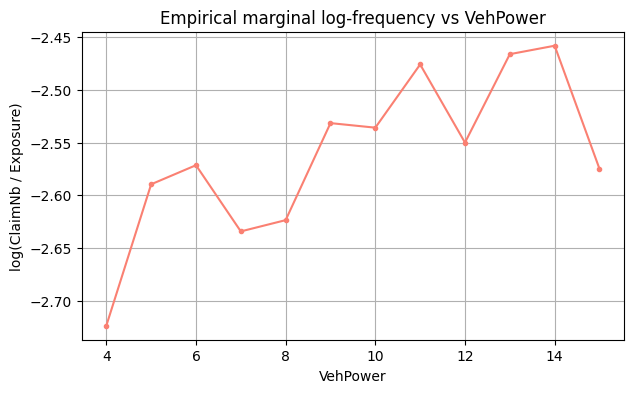

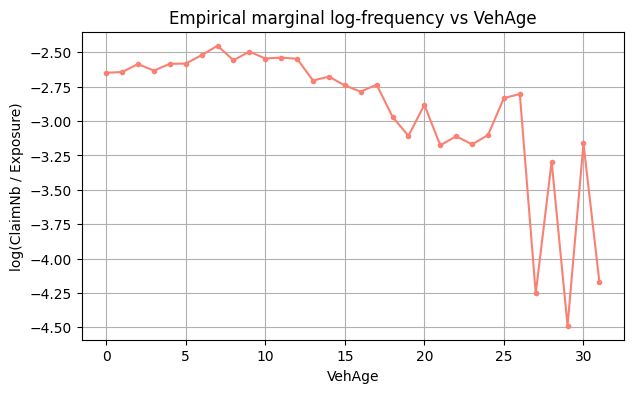

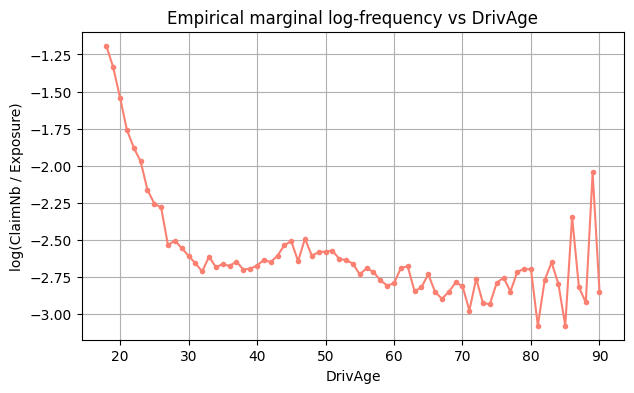

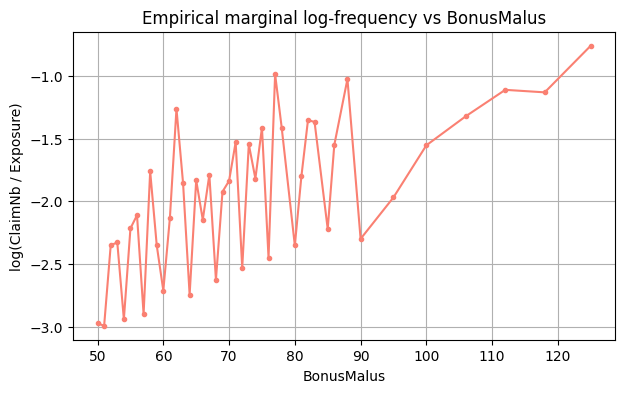

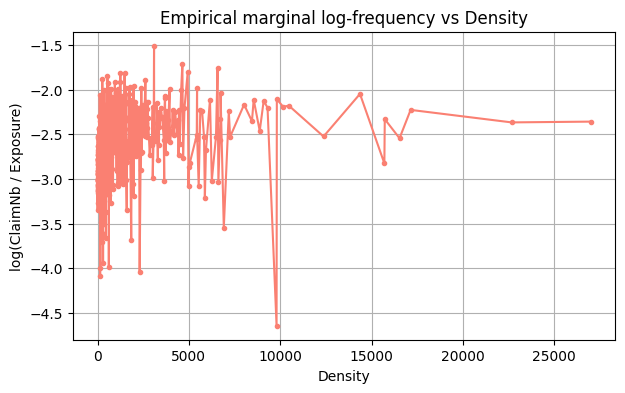

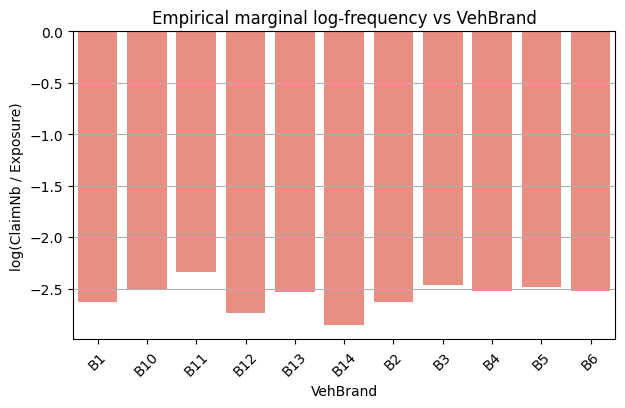

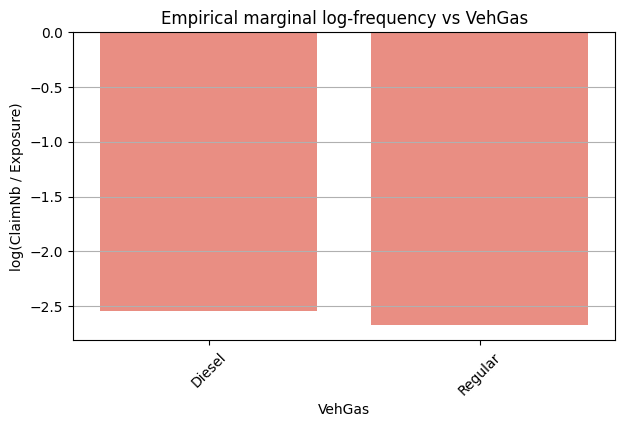

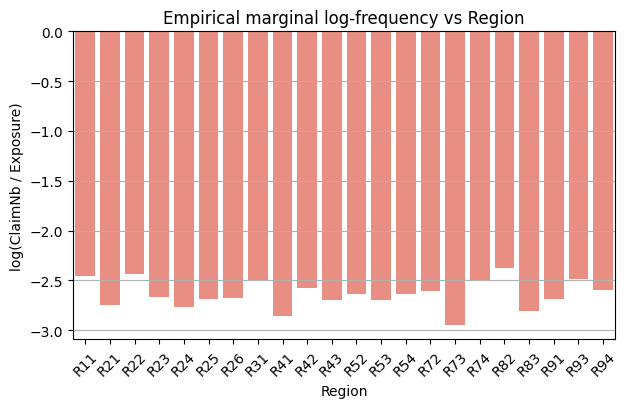

In [430]:
# We work on the raw data (no standardization, no one-hot encoding)
# We remove feature values with very small total exposure to ensure stability of empirical estimates 

def empirical_log_frequency(data, feature, claim_col, exposure_col, min_exposure=100):

    # feature values with total exposure below a threshold will be removed just to make the plot better to interpret
    grouped = (data.groupby(feature).agg({claim_col: "sum", exposure_col: "sum"}))
    grouped = grouped[grouped[exposure_col] >= min_exposure]

    # avoid log(0)
    epsilon = 1e-10
    grouped["log_frequency"] = np.log((grouped[claim_col] + epsilon) / (grouped[exposure_col] + epsilon))

    return grouped


for feature in numeric_features:
    log_freq = empirical_log_frequency(data, feature, target, exposure)
    log_freq = log_freq.sort_index()

    plt.figure(figsize=(7, 4))
    plt.plot(log_freq.index,log_freq["log_frequency"],marker=".",linestyle="-", color="salmon")
    plt.xlabel(feature)
    plt.ylabel("log(ClaimNb / Exposure)")
    plt.title(f"Empirical marginal log-frequency vs {feature}")
    plt.grid(True)
    plt.show()


for feature in categorical_features:
    log_freq = empirical_log_frequency(data, feature, target, exposure)
    #log_freq = log_freq.sort_values("log_frequency")

    plt.figure(figsize=(7, 4))
    sns.barplot(x=log_freq.index.astype(str),y=log_freq["log_frequency"], color="salmon")
    plt.xlabel(feature)
    plt.ylabel("log(ClaimNb / Exposure)")
    plt.title(f"Empirical marginal log-frequency vs {feature}")
    plt.xticks(rotation=45)
    plt.grid(axis="y")
    plt.show()


C:\Users\HY\AppData\Local\Temp\ipykernel_20632\1512735332.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = (data.groupby(feature).agg({claim_col: "sum", exposure_col: "sum"}))


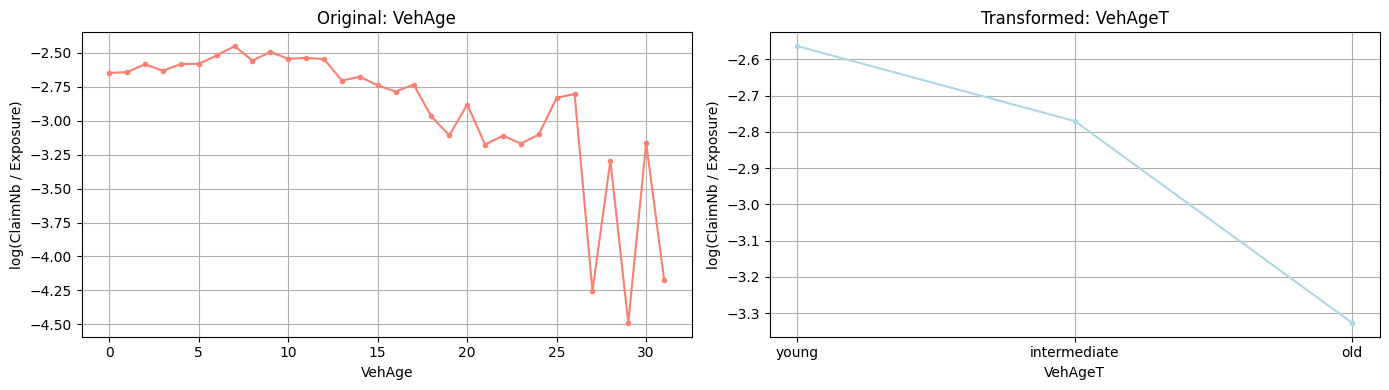

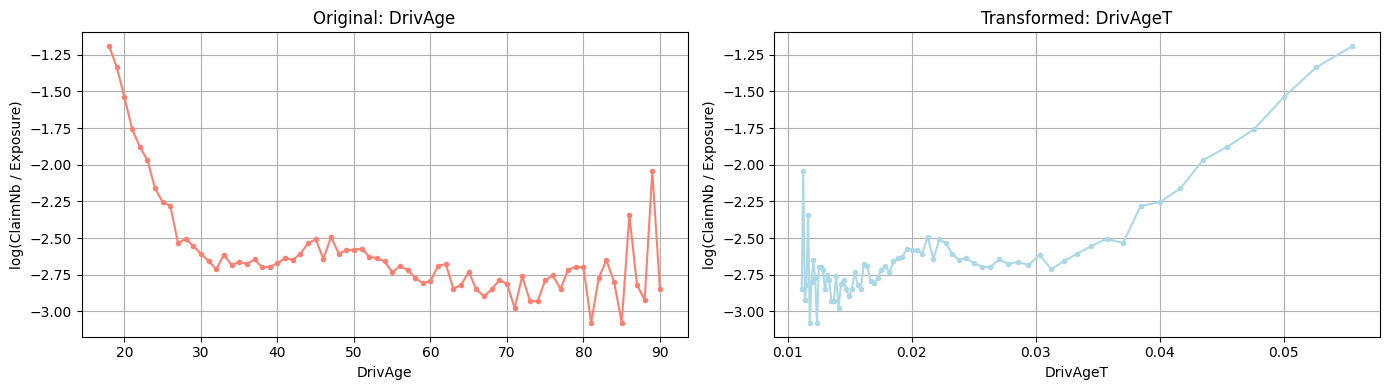

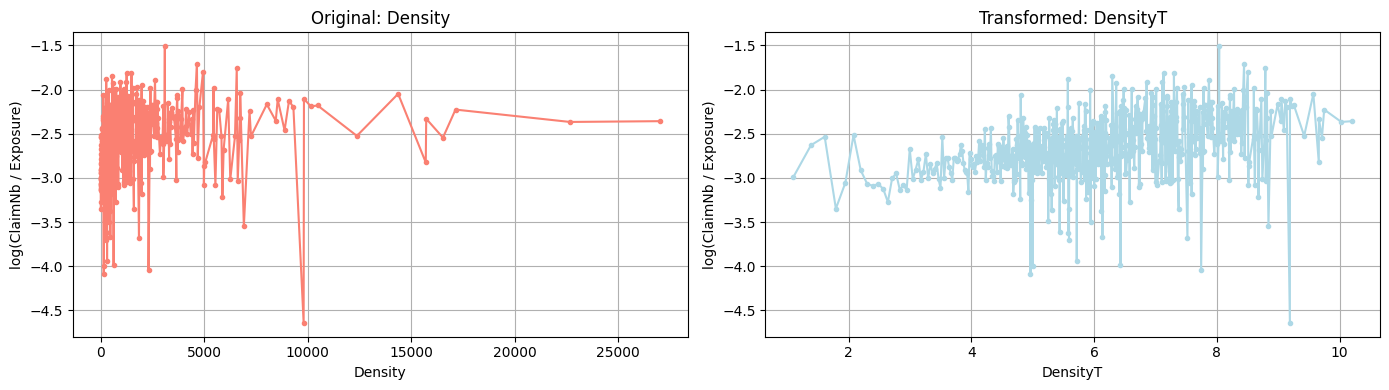

In [431]:
# Propose feature transformations. Justify your choices

# observations from plots

# VehPower:
# empirical log-frequency increases roughly linearly with vehicle power,
# so we keep VehPower

# VehAge:
# no global linear trend
# For young vehicles (0-12y), log-frequency is nearly flat; 
# for intermediate ages (13-24) it decreases,
# but for very old vehicles (>26) the estimates become unstable (maybe due to low exposure)
# This piecewise behavior violates the log-linear assumption of the Poisson GLM.

# Transformation:
bins = [0, 12, 24, 100]
labels = ["young", "intermediate", "old"]
data["VehAgeT"] = pd.cut(data["VehAge"], bins=bins, labels=labels)
# this makes it now a categorical feature!!


# DrivAge:
# high claim frequency for young drivers, followed by a sharp decrease
# almost a plateau for older drivers

# Transformation: 
data["DrivAgeT"] = 1/data["DrivAge"]

# BonusMalus:
# varies approximately linearly with BonusMalus (though a little noisy)
# keep BonusMalus

# Density:
# noisy and highly skewed 
# clear non-linear relationship

# Transformation: apply logarithmic transformation
data["DensityT"] = np.log(data["Density"])

# VehBrand:
# discrete risk levels with no natural ordering between brands
# keep VehBrand

# VehGas:
# keep VehGas as a binary

# Region:
# keep Region


# plots to visualize that these now have improved linear dependence

feature_pairs = [
    ("VehAge", "VehAgeT"),
    ("DrivAge", "DrivAgeT"),
    ("Density", "DensityT")
]

for original, transformed in feature_pairs:
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))  # 1 row, 2 columns

    # Original feature
    log_freq_orig = empirical_log_frequency(data, original, target, exposure)
    log_freq_orig = log_freq_orig.sort_index()
    axes[0].plot(log_freq_orig.index, log_freq_orig["log_frequency"],
                 marker=".", linestyle="-", color="salmon")
    axes[0].set_title(f"Original: {original}")
    axes[0].set_xlabel(original)
    axes[0].set_ylabel("log(ClaimNb / Exposure)")
    axes[0].grid(True)

    # Transformed feature
    log_freq_trans = empirical_log_frequency(data, transformed, target, exposure)
    log_freq_trans = log_freq_trans.sort_index()
    axes[1].plot(log_freq_trans.index, log_freq_trans["log_frequency"],
                 marker=".", linestyle="-", color="lightblue")
    axes[1].set_title(f"Transformed: {transformed}")
    axes[1].set_xlabel(transformed)
    axes[1].set_ylabel("log(ClaimNb / Exposure)")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()



### Question 1.c

In [432]:
# Train a Poisson GLM using your feature transformations
numeric_features_T = ["VehPower", "DrivAgeT", "BonusMalus", "DensityT"]
categorical_features_T = ["VehBrand", "VehGas", "Region", "VehAgeT"]

features_T = numeric_features_T + categorical_features_T
target = "ClaimNb"
exposure = "Exposure"

preprocessor_T = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features_T),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features_T),
    ]
)

X = data[features_T]
y = data[target]
exposure_data = data[exposure]

X_train, X_test, y_train, y_test, exposure_train, exposure_test = train_test_split(
    X, y, exposure_data, test_size=0.1, random_state=42
)


model_T = Pipeline(steps=[("preprocessor", preprocessor_T),("regressor", PoissonRegressor(alpha=0, max_iter=1000))])

model_T.fit( X_train, y_train,regressor__sample_weight=exposure_train)

y_train_pred = model_T.predict(X_train)
y_test_pred = model_T.predict(X_test)

train_mae_old = train_mae
test_mae_old = test_mae
train_mse_old = train_mse
test_mse_old = test_mse
train_loss_old = train_loss
test_loss_old = test_loss

# old results
print("OLD RESULTS FROM 1.a")

print(f"Train MAE:\t\t {train_mae_old:.4f},\t\tTest MAE:\t\t {test_mae_old:.4f}")
print(f"Train MSE:\t\t {train_mse_old:.4f},\t\tTest MSE:\t\t {test_mse_old:.4f}")
print(f"Train Poisson Deviance:\t {train_loss_old:.4f},\t\tTest Poisson Deviance:\t {test_loss_old:.4f}\n")

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

train_loss = mean_poisson_deviance(y_train, y_train_pred, sample_weight=exposure_train)
test_loss = mean_poisson_deviance(y_test, y_test_pred, sample_weight=exposure_test)

train_mae_new = train_mae
test_mae_new = test_mae
train_mse_new = train_mse
test_mse_new = test_mse
train_loss_new = train_loss
test_loss_new = test_loss

# Print MAE, MSE and loss on train and test data sets
print("NEW RESULTS WITH FEATURE ENGINEERING")
print(f"Train MAE:\t\t {train_mae:.4f},\t\tTest MAE:\t\t {test_mae:.4f}")
print(f"Train MSE:\t\t {train_mse:.4f},\t\tTest MSE:\t\t {test_mse:.4f}")
print(f"Train Poisson Deviance:\t {train_loss:.4f},\t\tTest Poisson Deviance:\t {test_loss:.4f}\n")

# Make sure your model outperforms the model of Question 1.a
def improvement(old, new):
    return (old - new) / old * 100

print("Percentage improvement:")
print(f"Train MAE improvement: {improvement(train_mae_old, train_mae_new):.2f}%")
print(f"Test MAE improvement: {improvement(test_mae_old, test_mae_new):.2f}%")
print(f"Train MSE improvement: {improvement(train_mse_old, train_mse_new):.2f}%")
print(f"Test MSE improvement: {improvement(test_mse_old, test_mse_new):.2f}%")
print(f"Train Poisson Deviance improvement: {improvement(train_loss_old, train_loss_new):.2f}%")
print(f"Test Poisson Deviance improvement: {improvement(test_loss_old, test_loss_new):.2f}%")

OLD RESULTS FROM 1.a
Train MAE:		 0.0870,		Test MAE:		 0.0857
Train MSE:		 0.0423,		Test MSE:		 0.0407
Train Poisson Deviance:	 0.2998,		Test Poisson Deviance:	 0.2941

NEW RESULTS WITH FEATURE ENGINEERING
Train MAE:		 0.0864,		Test MAE:		 0.0852
Train MSE:		 0.0424,		Test MSE:		 0.0408
Train Poisson Deviance:	 0.2989,		Test Poisson Deviance:	 0.2932

Percentage improvement:
Train MAE improvement: 0.67%
Test MAE improvement: 0.58%
Train MSE improvement: -0.12%
Test MSE improvement: -0.15%
Train Poisson Deviance improvement: 0.31%
Test Poisson Deviance improvement: 0.31%


# Exercise 2 (Poisson FNN)

### Question 2.a

In [433]:
# Neural network implementation

### Question 2.b

In [434]:
# Train Poisson feedforward neural network model

# Print MAE, MSE and loss on train and test data sets

# Make sure your model outperforms the Poisson GLM model of Question 1.b.

# Exercise 3 (Tree-based methods)

### Question 3.a

In [435]:
# Implement a regression tree

# Cross-validation

# Print MAE, MSE and loss on train and test data sets

### Question 3.b

In [436]:
# Implement a random forest model

# Cross-validation

# Print MAE, MSE and loss on train and test data sets

### Question 3.c

In [437]:
# Implement gradient boosted trees

# Cross-validation

# Print MAE, MSE and loss on train and test data sets